In [120]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
from sklearn import compose, datasets, metrics, model_selection, preprocessing
from sklearn import utils

# Softmax Regression from Scratch with Numpy

## Small example with synthetic data

In [4]:
datasets.make_classification?

In [87]:
prng = np.random.RandomState(42)

X, y = datasets.make_classification(
    #n_features=2,
    #n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3,
    shuffle=True,
    random_state=prng,
)

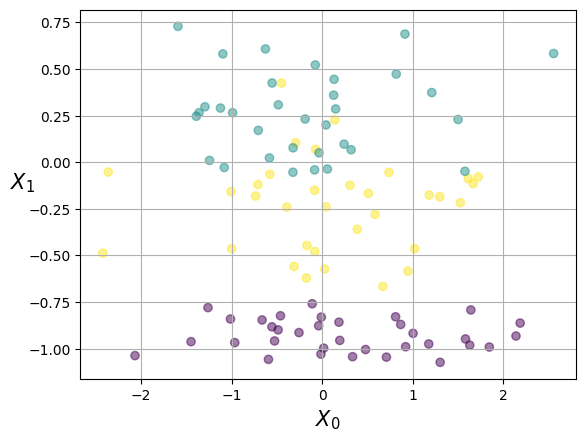

In [88]:
_ = plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5)
_ = plt.xlabel(r"$X_0$", fontsize=15)
_ = plt.ylabel(r"$X_1$", fontsize=15, rotation=0)
_ = plt.grid()

### Train-test split

In [89]:
train_features, test_features, train_target, test_target = (
    model_selection.train_test_split(
        X,
        y,
        random_state=prng,
        stratify=y,
        test_size=0.1
    )
)

### Estimating probabilities

In [90]:
def linear_model(X, beta):
    y_hat = X @ beta
    return y_hat


def softmax(y_hat):
    return np.exp(y_hat) / np.sum(np.exp(y_hat))


def predict_proba(X, theta):
    y_hat = linear_model(X, theta)
    return softmax(y_hat)


def predict(X, theta):
    probas = predict_proba(X, theta)
    return np.argmax(probas, axis=1)



### Cross Entropy Loss Function

In [91]:
def cross_entropy_loss(y, probas):
    return -np.mean(np.sum(y * np.log(probas)))


def cross_entropy_grad(theta, X, y):
    m, _ = X.shape
    probas = predict_proba(X, theta)
    return -(1 / m) * X.T @ (y - probas)


### Preparing the targets

In [92]:
label_binarizer = preprocessing.LabelBinarizer()
binarized_train_target = label_binarizer.fit_transform(train_target)
binarized_test_target = label_binarizer.transform(test_target)

### Training

In [93]:
def model_fn(X, learned_parameters):
    return predict_proba(X, learned_parameters)


def loss_fn(y, predictions):
    return cross_entropy_loss(y, predictions)


def grad_fn(theta, X, y):
    return cross_entropy_grad(theta, X, y)



In [94]:
# initialize weights
learned_parameters = prng.normal(loc=0, scale=1, size=(20, 3))

learning_rate = 0.001
batch_size = 1
epochs = 100
log_epochs = 10

for epoch in range(epochs):

    total_loss = 0.0
    for batch_ixs in utils.gen_batches(len(binarized_train_target), batch_size):
        features, target = train_features[batch_ixs], binarized_train_target[batch_ixs]

        # forward pass
        predictions = model_fn(features, learned_parameters)
        loss = loss_fn(target, predictions)
        total_loss += loss

        # backward pass
        grad = grad_fn(learned_parameters, features, target)
        learned_parameters -= grad * learning_rate

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {total_loss / len(binarized_train_target):.4f}')

Epoch 0  Loss 4.4943
Epoch 10  Loss 2.8243
Epoch 20  Loss 1.9225
Epoch 30  Loss 1.3256
Epoch 40  Loss 0.9155
Epoch 50  Loss 0.6555
Epoch 60  Loss 0.4985
Epoch 70  Loss 0.3973
Epoch 80  Loss 0.3265
Epoch 90  Loss 0.2742


In [95]:
print(f'Final Parameters:\n {learned_parameters}')

Final Parameters:
 [[-0.32656368  0.0523629  -0.0852588 ]
 [-1.45653354 -0.33583428  1.14608796]
 [-0.75865731  0.91534917 -0.60405153]
 [ 0.40733518  0.23378619  0.27183951]
 [-0.67035039  0.35780241 -0.35343976]
 [-1.35407139  1.92790776 -1.34841304]
 [-0.4827059  -1.31475903 -1.98781802]
 [ 0.35337277  1.67455301  0.97826617]
 [-0.29606585  0.0835864  -0.04720586]
 [ 0.08610586 -0.33648587  0.73100801]
 [ 1.78421543  1.23802307 -1.15019572]
 [ 0.48470445 -0.02478924  0.82437682]
 [-0.83331205  0.02702467 -0.01949881]
 [-0.01761401 -0.69018824 -0.44980994]
 [ 0.2476543   0.23987346 -0.09853755]
 [ 0.93551743  0.66177949 -0.08668254]
 [-1.25735839 -0.53980641 -0.73549096]
 [-0.80133842  0.25632795  0.38743742]
 [-0.3064391  -0.24927101 -0.45286726]
 [-0.68207769 -0.21921015 -0.40798504]]


In [96]:
total_loss = 0
for batch_ixs in utils.gen_batches(len(test_target), batch_size):
    features, target = test_features[batch_ixs], binarized_test_target[batch_ixs]
    predictions = model_fn(features, learned_parameters)
    loss = loss_fn(target, predictions)
    total_loss += loss

print(f"Average test loss: {total_loss / len(binarized_test_target)}")

Average test loss: 0.40017287412002905


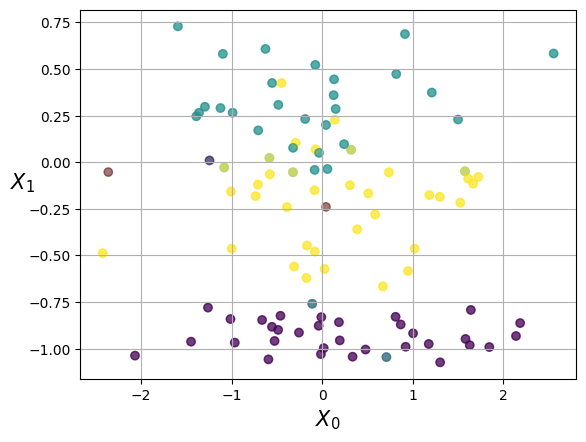

In [97]:
y_hat = predict(X, learned_parameters)
_ = plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5)
_ = plt.scatter(X[:, 0], X[:, 1], c=y_hat, marker='o', alpha=0.5)

_ = plt.xlabel(r"$X_0$", fontsize=15)
_ = plt.ylabel(r"$X_1$", fontsize=15, rotation=0)
_ = plt.grid()


## Example using a real data set

In [116]:
datasets.fetch_covtype?

In [117]:
bunch = datasets.fetch_covtype(
    data_home="/content/sample_datasets",
)

In [119]:
print(bunch["DESCR"])

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [108]:
features, targets = datasets.fetch_covtype(
    data_home="/content/sample_datasets",
    return_X_y=True,
    as_frame=True
)

In [109]:
features.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

In [111]:
features.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
targets.head()

0    5
1    5
2    2
3    2
4    5
Name: Cover_Type, dtype: int32

In [114]:
targets.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

### Train-test split

In [115]:
train_features, test_features, train_target, test_target = (
    model_selection.train_test_split(
        features,
        targets,
        random_state=prng,
        stratify=targets,
        test_size=0.1
    )
)

In [124]:
feature_preprocessor = compose.ColumnTransformer(
    transformers=[
        (
            "standard_scaler",
            preprocessing.StandardScaler(),
            [
                "Elevation",
                "Aspect",
                "Slope",
                "Horizontal_Distance_To_Hydrology",
                "Vertical_Distance_To_Hydrology",
                "Horizontal_Distance_To_Roadways",
                "Hillshade_9am",
                "Hillshade_Noon",
                "Hillshade_3pm",
                "Horizontal_Distance_To_Fire_Points"
            ]
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [127]:
scaled_train_features = feature_preprocessor.fit_transform(train_features)
scaled_test_features = feature_preprocessor.transform(test_features)

In [128]:
scaled_train_features.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
89693,0.394510,0.815011,-1.082717,1.588522,0.421518,2.038523,-0.191763,1.097365,0.874260,0.986120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443308,0.715857,1.082970,-0.815516,0.623915,1.313567,-0.156832,-0.490642,0.945548,1.031036,-0.748065,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493824,0.348093,1.002582,-1.216317,1.527352,1.553735,0.506775,-0.229123,0.945548,0.848130,-0.025551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268687,-2.904660,1.145493,0.654088,-1.070030,-0.745009,-0.746065,-1.798238,0.692520,1.788786,-1.099885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222689,0.548042,-1.310796,-0.281115,-0.844171,-0.727854,-0.035652,-0.229123,-0.370200,0.090379,0.201698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
label_binarizer = preprocessing.LabelBinarizer()
binarized_train_target = label_binarizer.fit_transform(train_target)
binarized_test_target = label_binarizer.transform(test_target)

### Using Stochastic Gradient Descent

In [137]:
# initialize weights
_, n = scaled_train_features.shape
learned_parameters = prng.normal(loc=0, scale=1, size=(n, 7))

learning_rate = 1e-3
batch_size = 10
epochs = 10
log_epochs = 1

for epoch in range(epochs):

    total_loss = 0.0
    for batch_ixs in utils.gen_batches(len(binarized_train_target), batch_size):
        features = scaled_train_features[batch_ixs]
        target = binarized_train_target[batch_ixs]

        # forward pass
        predictions = model_fn(features, learned_parameters)
        loss = loss_fn(target, predictions)
        total_loss += loss

        # backward pass
        grad = grad_fn(learned_parameters, features, target)
        learned_parameters -= grad * learning_rate

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {total_loss / len(binarized_train_target):.4f}')

Epoch 0  Loss 0.5160
Epoch 1  Loss 0.7290
Epoch 2  Loss 1.0122
Epoch 3  Loss 1.3025
Epoch 4  Loss 1.5960
Epoch 5  Loss 1.8914
Epoch 6  Loss 2.1882


KeyboardInterrupt: ignored

In [ ]:
print(f'Final Parameters: {learned_parameters}')

Final Parameters: [-1.10725523 -0.05814325 -1.30853076 -1.83678803  0.10419261  1.17608251
 -1.04297378 -1.15362118 -0.24784804 -0.57588507 -2.04047112  0.53037089
 -0.46756827  0.17389439 -0.78511921  0.22252837  0.86483406 -0.42191384
  0.40591846  1.45327641 -1.50378517 -1.77249324  0.56369636  0.73449754
 -0.37826558  0.22835001 -1.36259365 -0.41677784 -0.82045322 -0.89583145]


In [ ]:
train_predictions = model_fn(scaled_train_features, learned_parameters)
training_loss = loss_fn(binarized_train_target, train_predictions)
print(f"Training loss: {training_loss}")

Training loss: 0.057728822839751115


In [ ]:
test_predictions = model_fn(scaled_test_features, learned_parameters)
test_loss = loss_fn(binarized_test_target, test_predictions)
print(f"Test loss: {test_loss}")

Test loss: 0.07058017778866699


### Exercise

Compute accuracy, precision, recall, and a fourth metric of your choice on both the training and testing data and interpret your results.